<a href="https://colab.research.google.com/github/Lynda-Starkus/TS-statistical-models/blob/master/implementation_and_comparing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
#Importer les librairies utiles

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from scipy import stats
from scipy.stats import norm, skew

import sys, os
import random

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
from IPython import display, utils

In [27]:
#days, hours, minutes = td.days, td.seconds // 3600, td.seconds // 60 % 60
#Read csv files
solar_wind = pd.read_csv("solar_wind.csv")
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period","timedelta"], inplace=True)

dst = pd.read_csv("dst_labels.csv")
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period","timedelta"], inplace=True)

sunspots = pd.read_csv("sunspots.csv")
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period","timedelta"], inplace=True)


In [28]:
dst.groupby("period").describe()

dst                                                    
           count       mean        std    min   25%   50%  75%   max
period                                                              
train_a  28824.0 -16.576707  26.083191 -387.0 -26.0 -12.0 -1.0  65.0
train_b  52584.0  -9.695154  16.443049 -223.0 -17.0  -7.0  1.0  59.0
train_c  58464.0  -9.556325  16.506404 -374.0 -16.0  -7.0  0.0  67.0

In [29]:
print("Solar wind shape: ", solar_wind.shape)
solar_wind.head()

Solar wind shape:  (11451, 15)


bx_gse  by_gse  bz_gse  theta_gse  phi_gse  bx_gsm  \
period  timedelta                                                             
train_a 0 days 00:00:00   -5.55    3.00    1.25      11.09   153.37   -5.55   
        0 days 00:01:00   -5.58    3.16    1.17      10.10   151.91   -5.58   
        0 days 00:02:00   -5.15    3.66    0.85       7.87   146.04   -5.15   
        0 days 00:03:00   -5.20    3.68    0.68       6.17   146.17   -5.20   
        0 days 00:04:00   -5.12    3.68    0.49       4.62   145.72   -5.12   

                         by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  density  \
period  timedelta                                                            
train_a 0 days 00:00:00    3.00    1.25      11.09   153.37  6.80     1.53   
        0 days 00:01:00    3.16    1.17      10.10   151.91  6.83     1.69   
        0 days 00:02:00    3.66    0.85       7.87   146.04  6.77     1.97   
        0 days 00:03:00    3.68    0.68       6.17   146.17  6.74     1.97   
        0 days 00:04:00    3.68    0.49       4.62   145.72  6.65     1.77   

                          speed  temperature source  
period  timedelta                                    
train_a 0 days 00:00:00  383.92     110237.0     ac  
        0 days 00:01:00  381.79     123825.0     ac  
        0 days 00:02:00  389.11      82548.0     ac  
        0 days 00:03:00  389.11      82548.0     ac  
        0 days 00:04:00  384.26      94269.0     ac

In [30]:
print("Sunspot shape: ", sunspots.shape)
sunspots.head()

Sunspot shape:  (192, 1)


smoothed_ssn
period  timedelta              
train_a 0 days             65.4
        13 days            72.0
        44 days            76.9
        74 days            80.8
        105 days           85.4

In [31]:
solar_wind.groupby("period").describe().T

period             train        train_a
bx_gse      count    0.0    9390.000000
            mean     NaN      -2.021825
            std      NaN       3.791232
            min      NaN     -18.110000
            25%      NaN      -5.040000
...                  ...            ...
temperature min      NaN   10158.000000
            25%      NaN   37691.750000
            50%      NaN   61924.500000
            75%      NaN   92099.750000
            max      NaN  818002.000000

[112 rows x 2 columns]

In [32]:
sunspots.groupby("period").describe().T

period                 train_a     train_b    train_c
smoothed_ssn count   40.000000   72.000000  80.000000
             mean   136.902500   51.850000  24.313750
             std     34.563168   39.200266  19.020414
             min     65.400000    3.900000   2.200000
             25%    108.375000   15.325000   7.775000
             50%    151.500000   43.150000  20.500000
             75%    164.400000   91.225000  38.525000
             max    175.200000  116.400000  69.500000

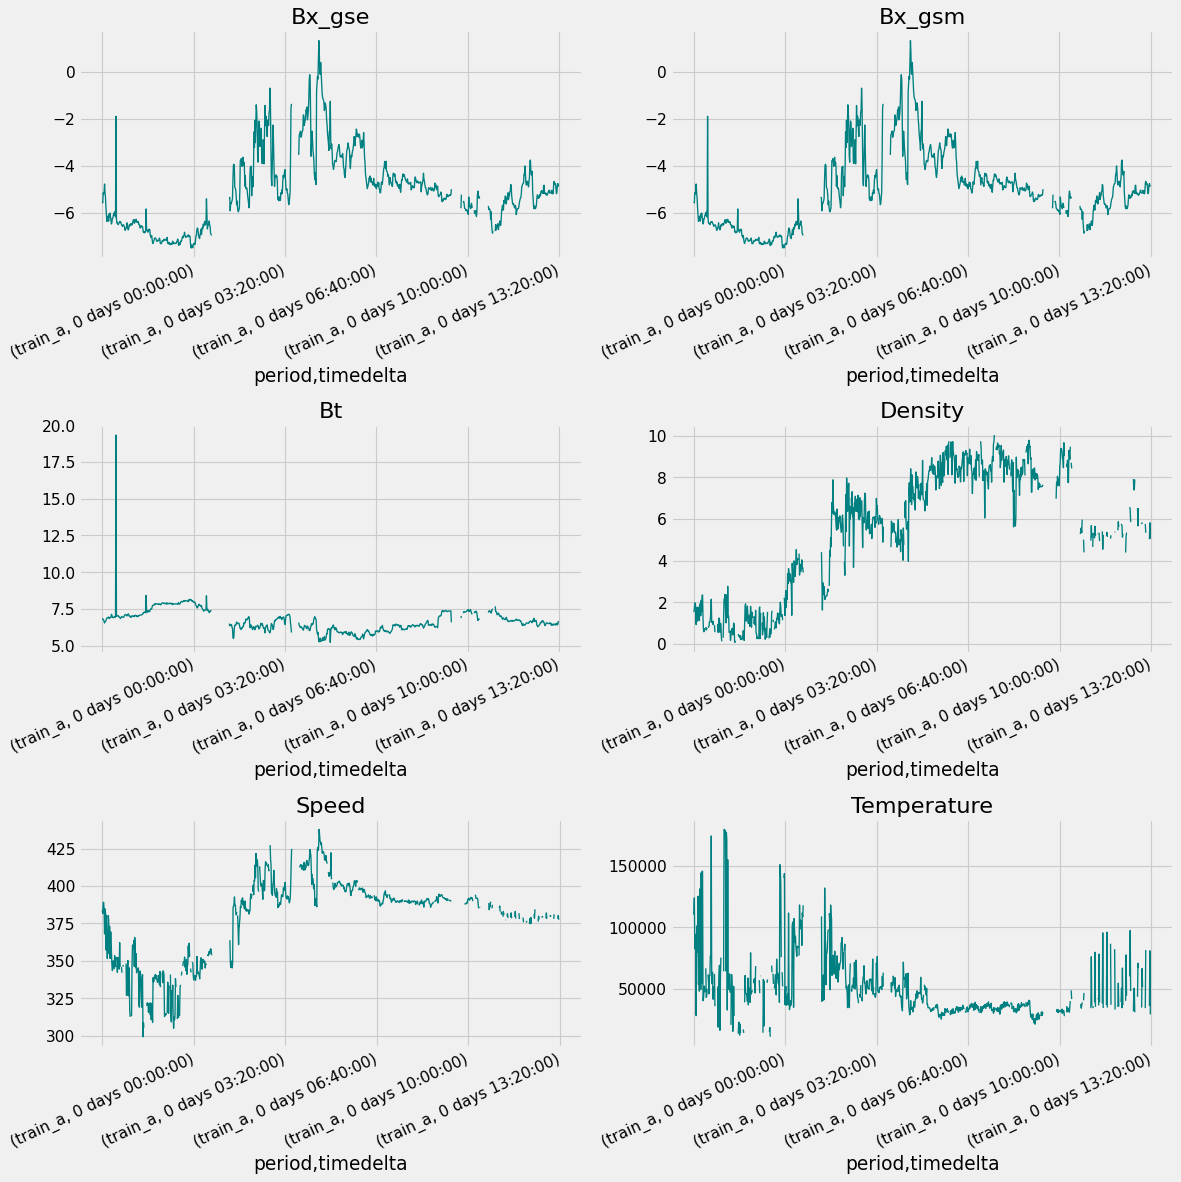

In [33]:
plt.style.use('fivethirtyeight')
def show_raw_visualization(data):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), dpi=80)
    for i, key in enumerate(data.columns):
        t_data = data[key]
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            title=f"{key.capitalize()}",
            rot=25,color='teal', lw=1.2
        )

    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()


cols_to_plot = ["bx_gse", "bx_gsm", "bt", "density", "speed", "temperature"]
show_raw_visualization(solar_wind[cols_to_plot].iloc[:1000])

In [34]:
solar_wind.isnull().sum()

bx_gse         2061
by_gse         2061
bz_gse         2061
theta_gse      2061
phi_gse        2061
bx_gsm         2061
by_gsm         2061
bz_gsm         2061
theta_gsm      2061
phi_gsm        2061
bt             2061
density        6172
speed          6171
temperature    6217
source         2049
dtype: int64

In [37]:
from sklearn.preprocessing import StandardScaler

# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = [
    "bt",
    "temperature",
    "bx_gse",
    "by_gse",
    "bz_gse",
    "speed",
    "density",
]

# all of the features we'll use, including sunspot numbers
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)


def impute_features(feature_df):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # interpolate between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]

    # aggregate solar wind data and join with sunspots
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # impute missing values
    imputed = impute_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler

In [38]:
features, scaler = preprocess_features(solar_wind, sunspots, subset=SOLAR_WIND_FEATURES)
print(features.shape)
features.head()

(191, 15)


bt_mean    bt_std  temperature_mean  \
period  timedelta                                               
train_a 0 days 00:00:00 -0.304978  0.388103          0.029592   
        0 days 01:00:00 -0.269741 -0.316242         -0.323781   
        0 days 02:00:00 -0.126685 -0.460284         -0.647430   
        0 days 03:00:00 -0.156975 -0.330550          0.201107   
        0 days 04:00:00 -0.509675 -0.316397          0.239364   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.631430    -1.173720   -0.372268   
        0 days 01:00:00         1.540121    -1.329393   -0.722786   
        0 days 02:00:00        -0.288790    -1.480490   -0.900530   
        0 days 03:00:00         0.538125    -1.379441   -0.661724   
        0 days 04:00:00         0.340354    -0.918424   -0.446811   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00    -0.048707   -0.200198     0.041326   -0.734889   
        0 days 01:00:00    -0.247566   -0.411563     0.133911   -0.605575   
        0 days 02:00:00    -0.244248   -0.793049     0.339778   -0.952305   
        0 days 03:00:00    -0.708893    0.014545     0.245138   -0.385395   
        0 days 04:00:00    -0.335725    0.487651     0.147586   -0.567057   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -1.436420   1.265592     -0.943493    -0.550867   
        0 days 01:00:00   -2.278887   1.459023     -1.042536    -0.320698   
        0 days 02:00:00   -2.369267   0.815446     -1.024691    -0.573161   
        0 days 03:00:00   -1.734668  -0.301414     -0.514958     0.110881   
        0 days 04:00:00   -0.970653   1.489627     -0.477103    -0.078110   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00           0.0  
        0 days 01:00:00           0.0  
        0 days 02:00:00           0.0  
        0 days 03:00:00           0.0  
        0 days 04:00:00           0.0

In [39]:
assert (features.isna().sum() == 0).all()

In [40]:
features.tail()

bt_mean    bt_std  temperature_mean  \
period  timedelta                                               
train_a 7 days 18:00:00 -0.721413 -0.280086         -0.263370   
        7 days 19:00:00 -0.667524 -0.302596          0.179399   
        7 days 20:00:00 -0.626124 -0.435475          1.070157   
        7 days 21:00:00 -0.668862 -0.367864          0.480550   
        7 days 22:00:00 -0.685681 -0.425947         -1.077032   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 7 days 18:00:00        -0.211386     0.404935   -0.319513   
        7 days 19:00:00         0.206958     1.141866    0.607992   
        7 days 20:00:00        -0.161005     1.753417   -0.764530   
        7 days 21:00:00         1.868641     1.844027   -0.680486   
        7 days 22:00:00         0.364377     1.999062   -0.772607   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 7 days 18:00:00     0.277220   -0.116819    -0.810618    0.082992   
        7 days 19:00:00    -0.390068    1.309247    -0.661287   -0.061441   
        7 days 20:00:00    -1.055143   -0.743949    -0.619833   -0.608873   
        7 days 21:00:00    -0.585106   -0.147669    -0.690804   -0.808232   
        7 days 22:00:00    -0.623000   -0.724888    -0.420887   -0.712884   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 7 days 18:00:00   -1.256527  -0.563706     -0.203179     0.071697   
        7 days 19:00:00   -1.238859   0.676280     -0.540421     0.386108   
        7 days 20:00:00   -0.975480  -0.442054     -0.853842    -0.895981   
        7 days 21:00:00   -1.812970   1.751338     -0.915539    -0.421691   
        7 days 22:00:00   -2.427606   0.959948     -1.027505    -0.617558   

                         smoothed_ssn  
period  timedelta                      
train_a 7 days 18:00:00           0.0  
        7 days 19:00:00           0.0  
        7 days 20:00:00           0.0  
        7 days 21:00:00           0.0  
        7 days 22:00:00           0.0

In [41]:
from sklearn.model_selection import train_test_split

def get_train_test_val(data, test_per_period, val_per_period):
    """Splits data across periods into train, test, and validation"""
    # assign the last `test_per_period` rows from each period to test
    test = data.groupby("period").tail(test_per_period)
    interim = data[~data.index.isin(test.index)]
    # assign the last `val_per_period` from the remaining rows to validation
    val = data.groupby("period").tail(val_per_period)
    # the remaining rows are assigned to train
    train = interim[~interim.index.isin(val.index)]
    return train, test, val


train, test, val = get_train_test_val(features, test_per_period=6_000, val_per_period=3_000)

test.head()

bt_mean    bt_std  temperature_mean  \
period  timedelta                                               
train_a 0 days 00:00:00 -0.304978  0.388103          0.029592   
        0 days 01:00:00 -0.269741 -0.316242         -0.323781   
        0 days 02:00:00 -0.126685 -0.460284         -0.647430   
        0 days 03:00:00 -0.156975 -0.330550          0.201107   
        0 days 04:00:00 -0.509675 -0.316397          0.239364   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.631430    -1.173720   -0.372268   
        0 days 01:00:00         1.540121    -1.329393   -0.722786   
        0 days 02:00:00        -0.288790    -1.480490   -0.900530   
        0 days 03:00:00         0.538125    -1.379441   -0.661724   
        0 days 04:00:00         0.340354    -0.918424   -0.446811   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00    -0.048707   -0.200198     0.041326   -0.734889   
        0 days 01:00:00    -0.247566   -0.411563     0.133911   -0.605575   
        0 days 02:00:00    -0.244248   -0.793049     0.339778   -0.952305   
        0 days 03:00:00    -0.708893    0.014545     0.245138   -0.385395   
        0 days 04:00:00    -0.335725    0.487651     0.147586   -0.567057   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -1.436420   1.265592     -0.943493    -0.550867   
        0 days 01:00:00   -2.278887   1.459023     -1.042536    -0.320698   
        0 days 02:00:00   -2.369267   0.815446     -1.024691    -0.573161   
        0 days 03:00:00   -1.734668  -0.301414     -0.514958     0.110881   
        0 days 04:00:00   -0.970653   1.489627     -0.477103    -0.078110   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00           0.0  
        0 days 01:00:00           0.0  
        0 days 02:00:00           0.0  
        0 days 03:00:00           0.0  
        0 days 04:00:00           0.0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f659fb91c50>,
      dtype=object)

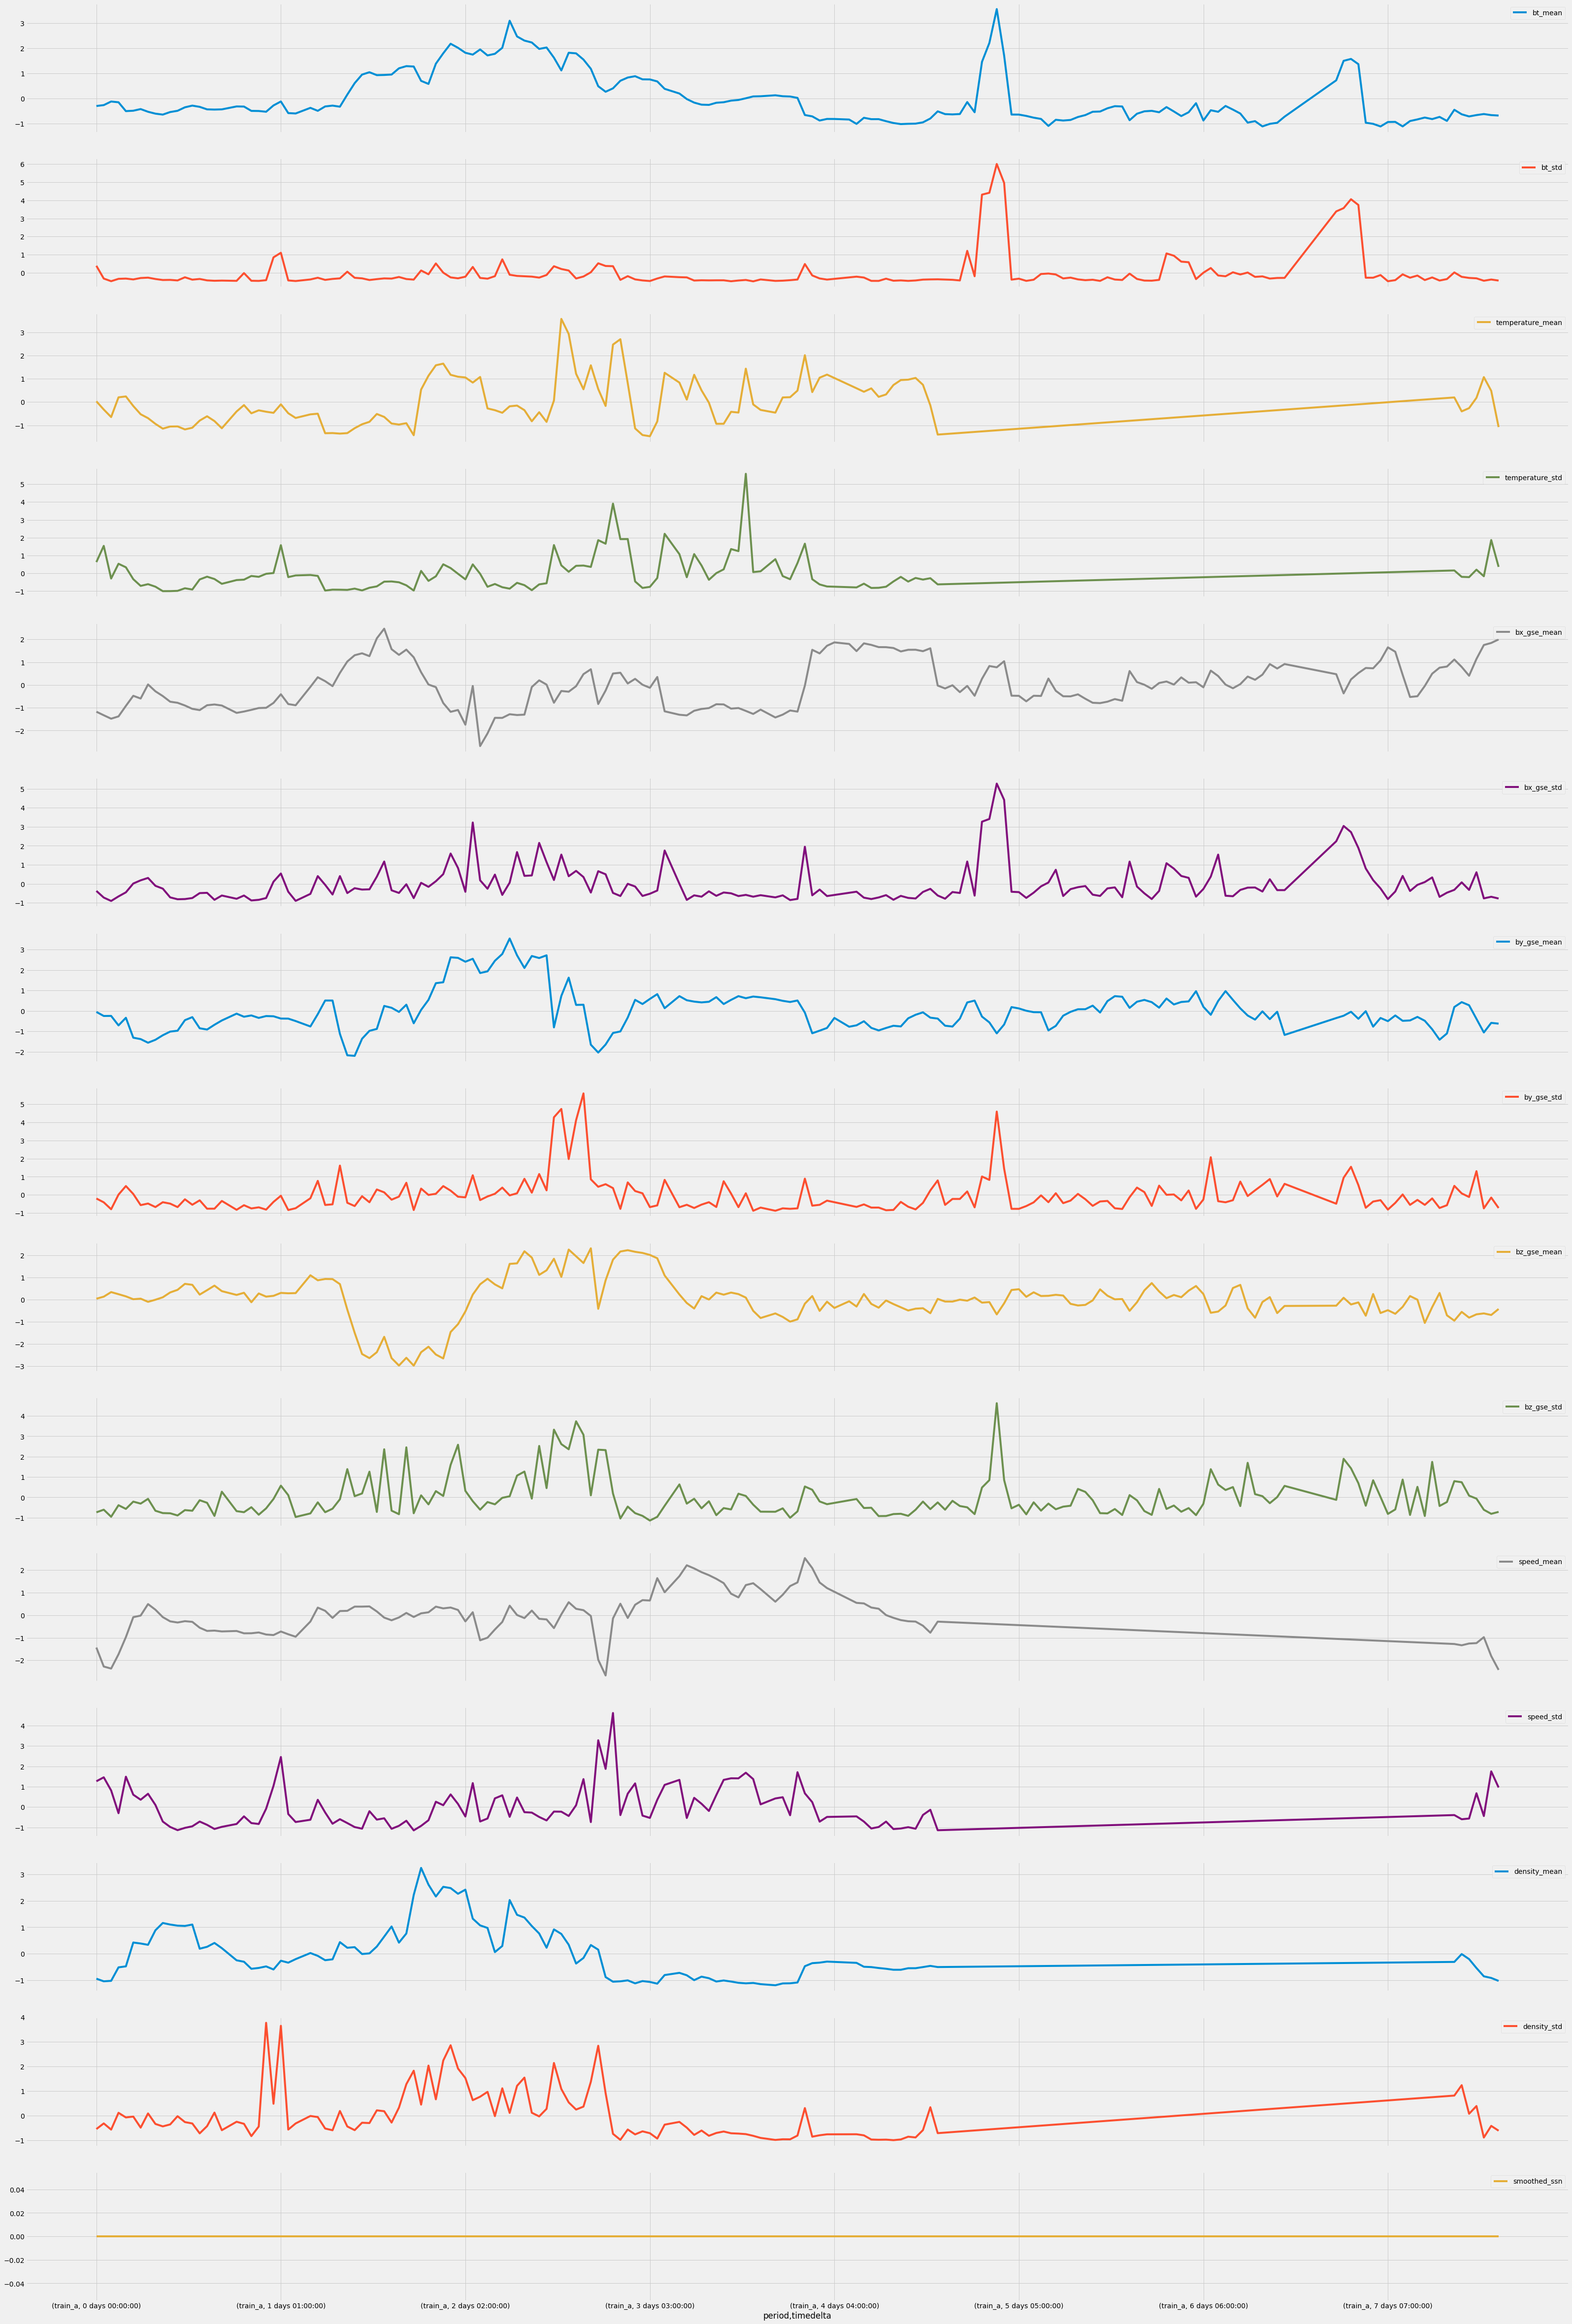

In [42]:
features.plot(subplots=True, figsize=(50,80))

In [43]:
features.tail()
#features_a = features[features['period'] == 'train_a']

bt_mean    bt_std  temperature_mean  \
period  timedelta                                               
train_a 7 days 18:00:00 -0.721413 -0.280086         -0.263370   
        7 days 19:00:00 -0.667524 -0.302596          0.179399   
        7 days 20:00:00 -0.626124 -0.435475          1.070157   
        7 days 21:00:00 -0.668862 -0.367864          0.480550   
        7 days 22:00:00 -0.685681 -0.425947         -1.077032   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 7 days 18:00:00        -0.211386     0.404935   -0.319513   
        7 days 19:00:00         0.206958     1.141866    0.607992   
        7 days 20:00:00        -0.161005     1.753417   -0.764530   
        7 days 21:00:00         1.868641     1.844027   -0.680486   
        7 days 22:00:00         0.364377     1.999062   -0.772607   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 7 days 18:00:00     0.277220   -0.116819    -0.810618    0.082992   
        7 days 19:00:00    -0.390068    1.309247    -0.661287   -0.061441   
        7 days 20:00:00    -1.055143   -0.743949    -0.619833   -0.608873   
        7 days 21:00:00    -0.585106   -0.147669    -0.690804   -0.808232   
        7 days 22:00:00    -0.623000   -0.724888    -0.420887   -0.712884   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 7 days 18:00:00   -1.256527  -0.563706     -0.203179     0.071697   
        7 days 19:00:00   -1.238859   0.676280     -0.540421     0.386108   
        7 days 20:00:00   -0.975480  -0.442054     -0.853842    -0.895981   
        7 days 21:00:00   -1.812970   1.751338     -0.915539    -0.421691   
        7 days 22:00:00   -2.427606   0.959948     -1.027505    -0.617558   

                         smoothed_ssn  
period  timedelta                      
train_a 7 days 18:00:00           0.0  
        7 days 19:00:00           0.0  
        7 days 20:00:00           0.0  
        7 days 21:00:00           0.0  
        7 days 22:00:00           0.0

In [ ]:
!pip install darts

In [ ]:
!pip install scalecast

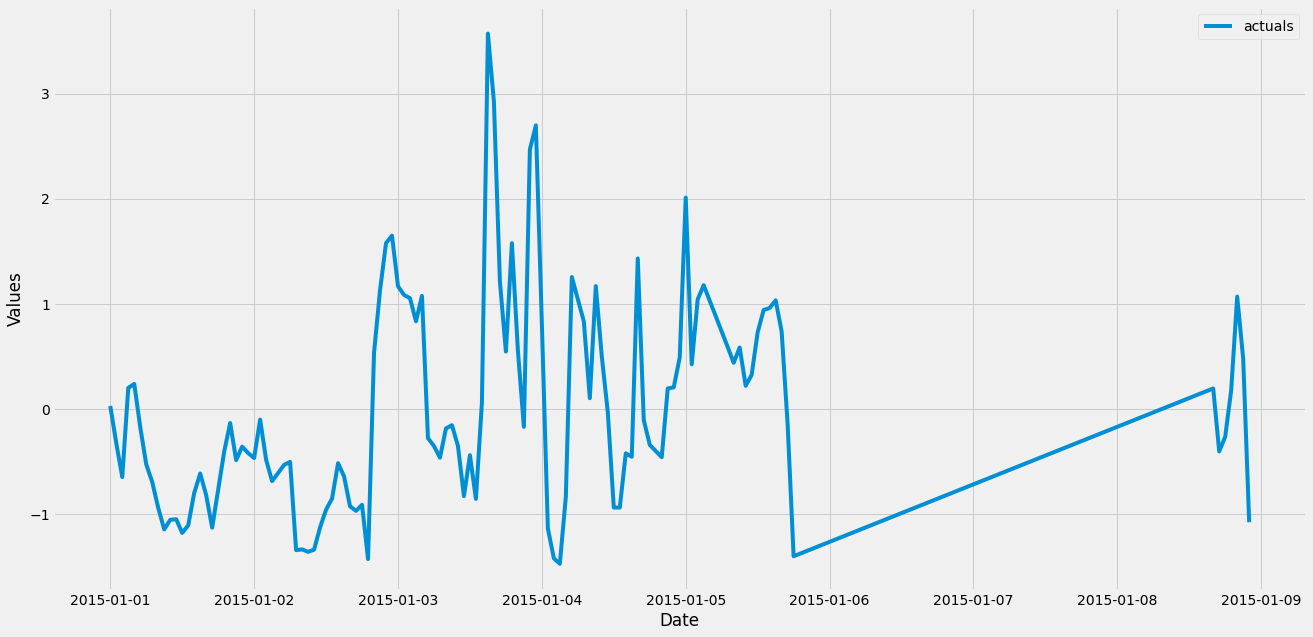

In [46]:
from scalecast.Forecaster import Forecaster
y = features['temperature_mean']
y = y.loc[['train_a']]

current_dates = pd.date_range(
    start='01-01-2015 00:00:00',
    freq='H',
    periods=len(y)
).to_list()
f = Forecaster(y=y,current_dates=current_dates)

#print(current_dates)
f.plot(figsize=(20,10))
plt.show()


In [47]:
f.set_test_length(.25)
f.generate_future_dates(48)

In [ ]:
from darts.utils.utils import (
    SeasonalityMode, 
    TrendMode, 
    ModelMode
)

theta_grid = {
    'theta':[0.5,1,1.5,2,2.5,3],
    'model_mode':[
        ModelMode.ADDITIVE,
        ModelMode.MULTIPLICATIVE
    ],
    'season_mode':[
        SeasonalityMode.MULTIPLICATIVE,
        SeasonalityMode.ADDITIVE
    ],
    'trend_mode':[
        TrendMode.EXPONENTIAL,
        TrendMode.LINEAR
    ],
}

f.set_validation_metric('mape')
f.set_estimator('theta')
f.ingest_grid(theta_grid)
f.cross_validate(k=3)

In [ ]:
f.auto_forecast()

In [ ]:
!pip install fbprophet

In [53]:
from prophet import Prophet 
from prophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [55]:
my_model = Prophet(interval_width=0.95)
y_prophet = pd.DataFrame(columns = ["ds","y"])
y_prophet["ds"] = y.index.get_level_values('timedelta').to_list()
y_prophet["ds"] = y_prophet["ds"].values.astype('datetime64[ns]')
y_prophet["y"] = y.values

y_prophet.head()

ds         y
0 1970-01-01 00:00:00  0.029592
1 1970-01-01 01:00:00 -0.323781
2 1970-01-01 02:00:00 -0.647430
3 1970-01-01 03:00:00  0.201107
4 1970-01-01 04:00:00  0.239364

In [56]:
my_model.fit(y_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [57]:
future_dates = my_model.make_future_dataframe(periods=48)
future_dates.head()

ds
0 1970-01-01 00:00:00
1 1970-01-01 01:00:00
2 1970-01-01 02:00:00
3 1970-01-01 03:00:00
4 1970-01-01 04:00:00

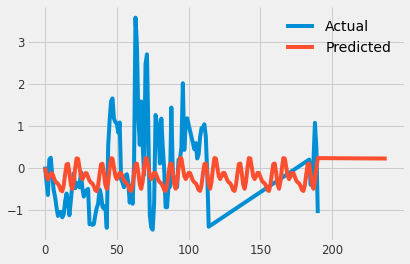

In [58]:
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()
#my_model.plot(forecast, uncertainty=True)

# plot expected vs actual
#mae = mean_absolute_error(y_prophet['y'].values, forecast['yhat'].values[:-48])
pyplot.plot(y_prophet['y'].values, label='Actual')
pyplot.plot(forecast['yhat'].values, label='Predicted')
pyplot.legend()
pyplot.show()

#print('MAE: %.3f' % mae)

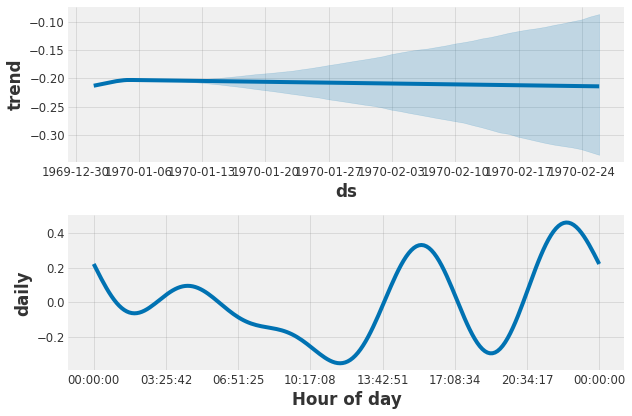

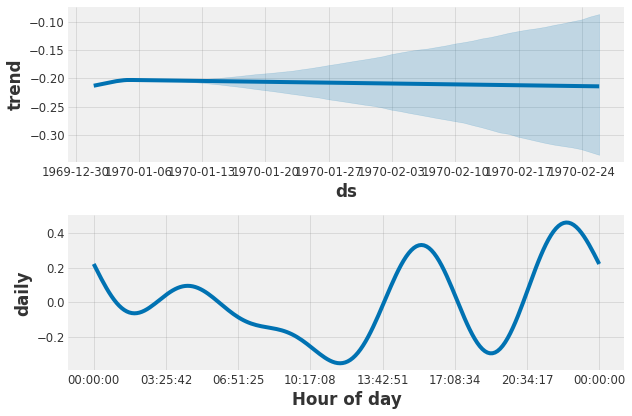

In [59]:
my_model.plot_components(forecast)

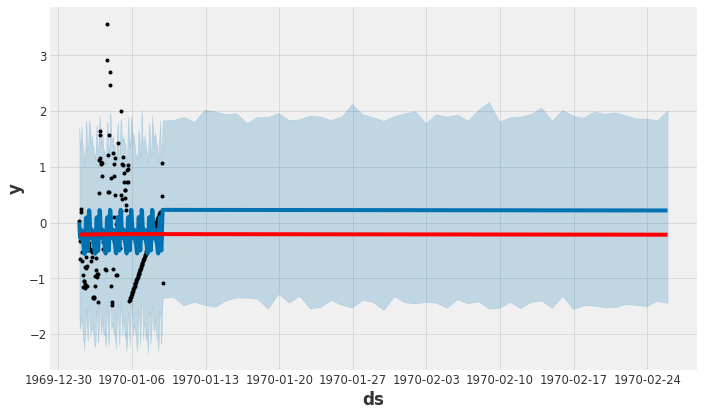

In [60]:
from prophet.plot import add_changepoints_to_plot
fig = my_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), my_model, forecast)

In [61]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose # holt winters 

from statsmodels.tsa.holtwinters import SimpleExpSmoothing 
from statsmodels.tsa.holtwinters import ExponentialSmoothing

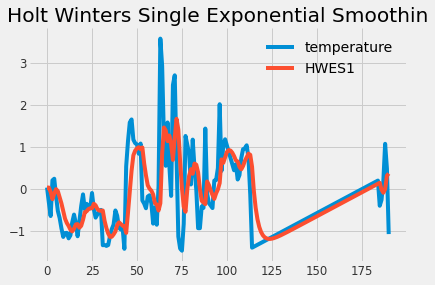

In [62]:

HW = pd.DataFrame(columns = ['temperature','HWES1'])
HW['temperature'] = y.values
HW['HWES1'] = SimpleExpSmoothing(y.values).fit(smoothing_level=0.3,optimized=False,use_brute=True).fittedvalues

HW[['temperature','HWES1']].plot(title='Holt Winters Single Exponential Smoothing')

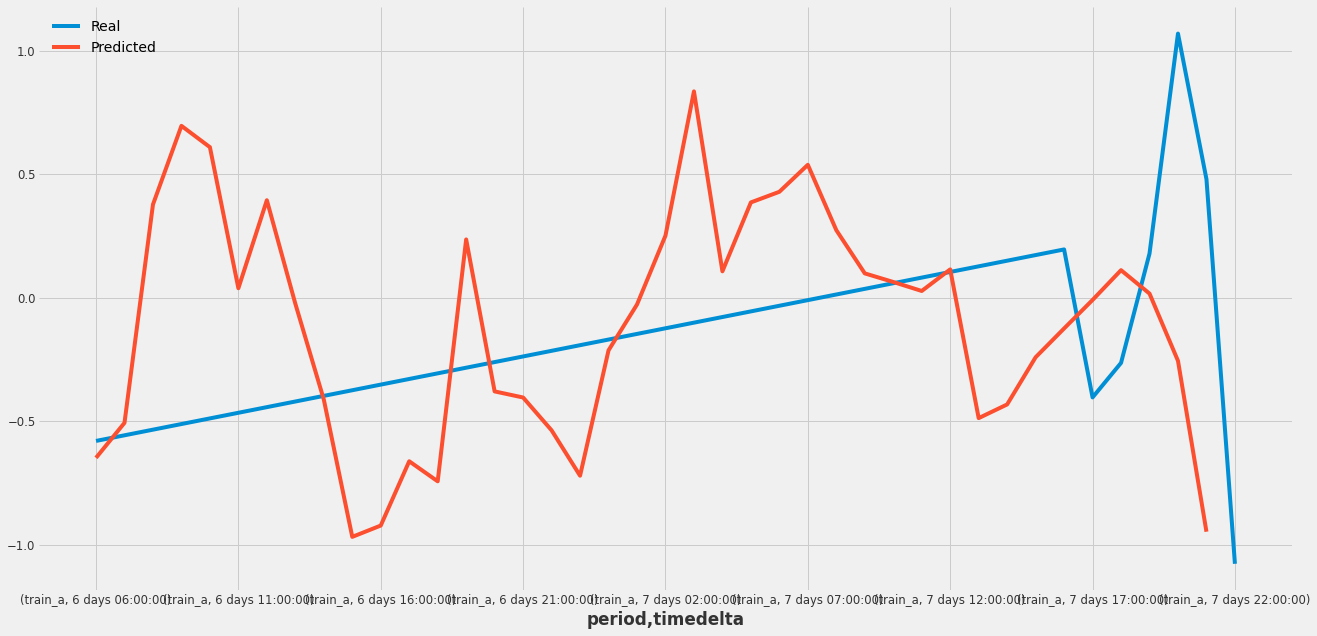

In [112]:
forecast = y
forecast.index.freq = 'H'

train_set = forecast[:150]

test_set = forecast[150:]

fitted_model = ExponentialSmoothing(train_set.values, trend='add', seasonal='add', seasonal_periods=75).fit()

test_predictions = fitted_model.forecast(40)

test_set.plot(legend=True, label='Real', figsize=(20,10))
test_results = pd.DataFrame(['Temperature'])
plt.plot(test_predictions, label='Predicted')
plt.legend()

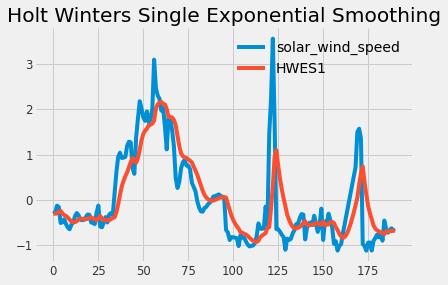

In [142]:
y = features['bt_mean']
y = y.loc[['train_a']]

HW = pd.DataFrame(columns = ['solar_wind_speed','HWES1'])
HW['solar_wind_speed'] = y.values
HW['HWES1'] = SimpleExpSmoothing(y.values).fit(smoothing_level=0.2,optimized=False,use_brute=True).fittedvalues

HW[['solar_wind_speed','HWES1']].plot(title='Holt Winters Single Exponential Smoothing')

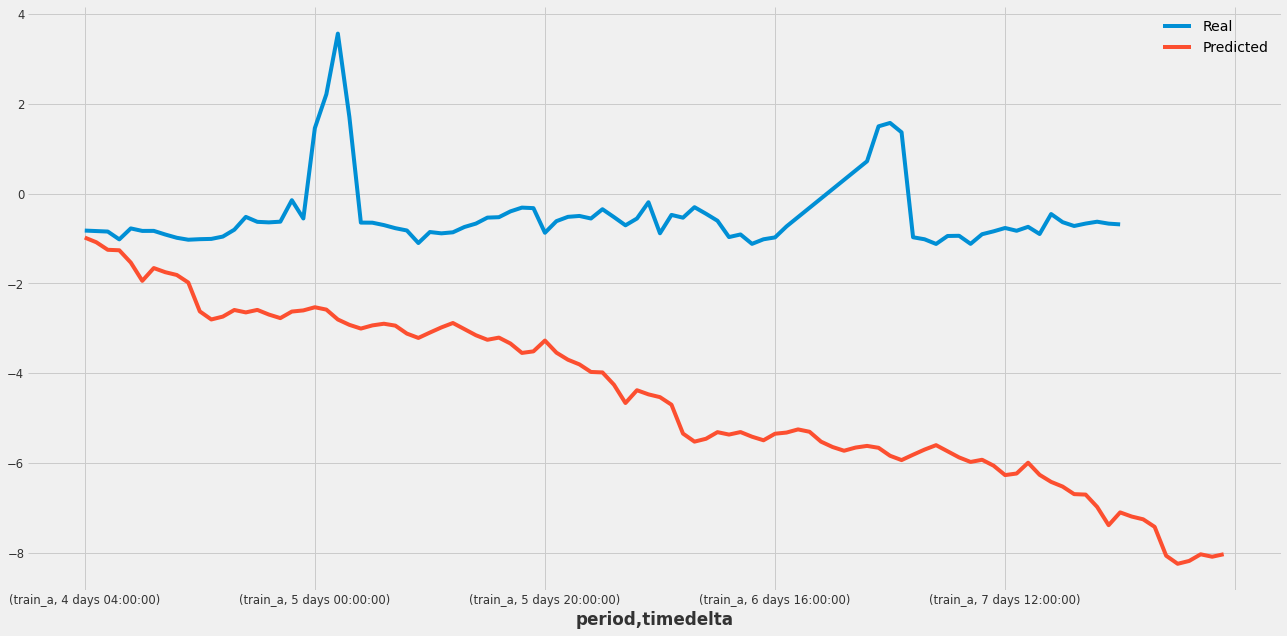

In [147]:
forecast = y
forecast.index.freq = 'H'

train_set = forecast[:100]

test_set = forecast[100:]

fitted_model = ExponentialSmoothing(train_set.values, trend='add', seasonal='add', seasonal_periods=42).fit()

test_predictions = fitted_model.forecast(100)

test_set.plot(legend=True, label='Real', figsize=(20,10))
test_results = pd.DataFrame(['Temperature'])
plt.plot(test_predictions, label='Predicted')
plt.legend()

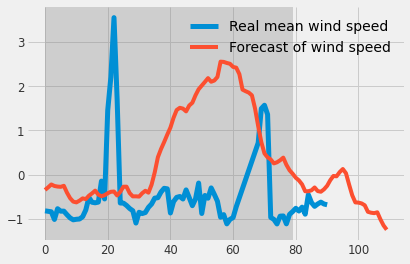

In [203]:

from typing import *
def initial_trend(series: List, uppercase_m: int) -> float:
    return sum([
        float(series[i+uppercase_m] - series[i]) / uppercase_m
        for i in range(uppercase_m)
    ]) / uppercase_m


def initial_seasonality(series: List, uppercase_m: int) -> List:
    initial_season = []
    n_seasons = int(len(series)/uppercase_m)

    season_averages = [sum(
        series[uppercase_m * i:uppercase_m * i + uppercase_m]
    ) / uppercase_m for i in range(n_seasons)]

    initial_season.extend([
        sum([series[uppercase_m*j+i]-season_averages[j]
             for j in range(n_seasons)]) / n_seasons
        for i in range(uppercase_m)
    ])

    return initial_season

def winters_es(series: List,
               uppercase_m: int,
               alpha: float=0.2,
               beta: float=0.2,
               gamma: float=0.015,
               future_steps: int=1) -> List:
    
    i_l = [series[0]]
    i_t = [initial_trend(series, uppercase_m)]
    i_s = initial_seasonality(series, uppercase_m)

    forecasts = []
    for t in range(len(series) + future_steps):

        if t >= len(series):
            k = t - len(series) + 1
            forecasts.append(
                (i_l[-1] + k * i_t[-1]) + i_s[t % uppercase_m]
            )

        else:
            l_t = alpha * (series[t] - i_s[t % uppercase_m]) + (1 - alpha) * (i_l[-1] + i_t[-1])

            i_t[-1] = beta * (l_t - i_l[-1]) + (1 - beta) * i_t[-1]
            i_l[-1] = l_t

            i_s[t % uppercase_m] = gamma * (series[t] - l_t) + (1 - gamma) * i_s[t % uppercase_m]

            forecasts.append(
                (i_l[-1] + i_t[-1]) + i_s[t % uppercase_m]
            )

    return forecasts

forecast = winters_es(y, 48)

data = y.values.tolist()

last_hours = list(range(0, 80))

train_set = data[:100]
test_set = data[100:]

forecast = winters_es(train_set, 10, future_steps=10)    
plt.plot(test_set, linewidth=5, label='Real mean wind speed')
plt.plot(forecast, linewidth=4, label='Forecast of wind speed')    
plt.axvspan(*(last_hours[0], last_hours[-1]), 
                  facecolor='grey', 
                  alpha=0.3)    
plt.legend()
plt.show()

In [206]:
from statsmodels.tsa.stattools import adfuller, kpss
X = y.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
 
result_kpss_ct=kpss(X,regression="ct")
print('Test Statistic: %f' %result_kpss_ct[0])
print('p-value: %f' %result_kpss_ct[1])
print('Critical values:')
for key, value in result_kpss_ct[3].items():
     print('\t%s: %.3f' %(key, value))


The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"




ADF Statistic: -2.555333
p-value: 0.102585
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575
Test Statistic: 0.119629
p-value: 0.098835
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216



The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"



The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.





ADF Statistic: -10.074939
p-value: 0.000000
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575
Test Statistic: 0.059676
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


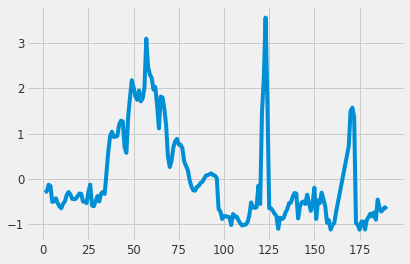

In [257]:
df_log=y
df_diff=df_log.diff().dropna()
X = df_diff
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
 
result_kpss_ct=kpss(X,regression="ct")
print('Test Statistic: %f' %result_kpss_ct[0])
print('p-value: %f' %result_kpss_ct[1])
print('Critical values:')
for key, value in result_kpss_ct[3].items():
     print('\t%s: %.3f' %(key, value))
plt.plot(trend.values)

MAPE =  2.6146701681906217
MSE =  0.10504464014160166


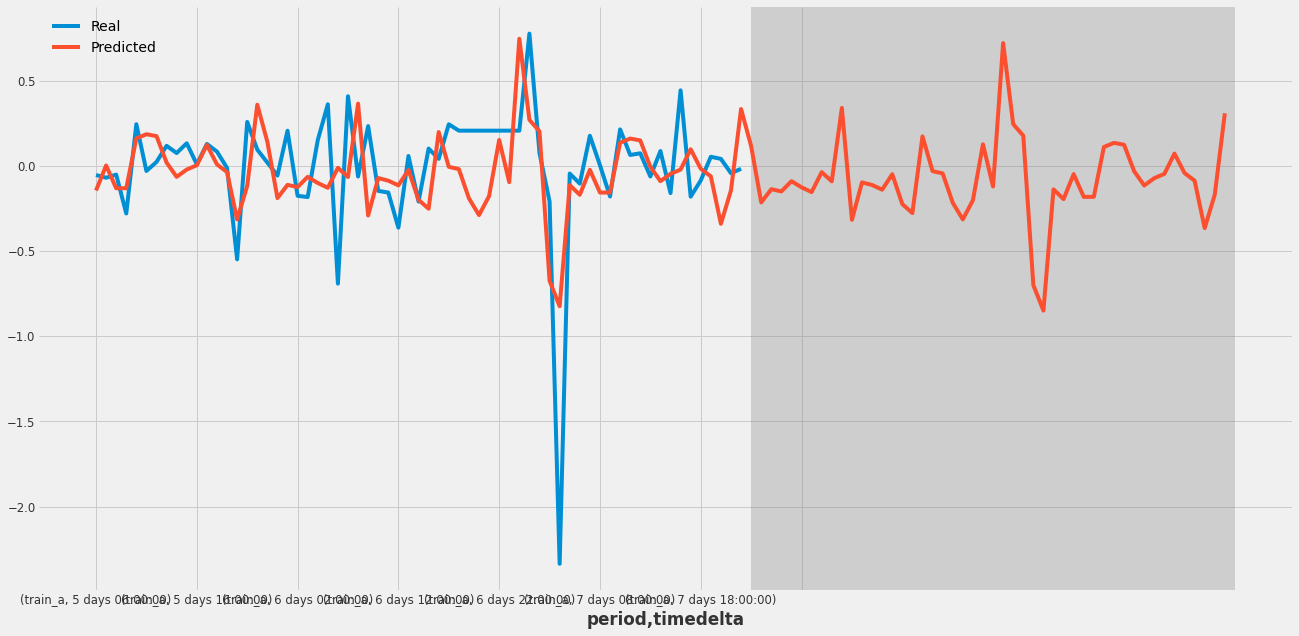

In [254]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse

forecast = df_diff
forecast.index.freq = 'H'

train_set = forecast[:125]

test_set = forecast[125:]

fitted_model = ExponentialSmoothing(train_set.values, trend='add', seasonal='add', seasonal_periods=48).fit()

test_predictions = fitted_model.forecast(113)


test_set.plot(legend=True, label='Real', figsize=(20,10))
test_results = pd.DataFrame(['Temperature'])
plt.plot(test_predictions, label='Predicted')
plt.legend()
plt.axvspan(*(65, 113), 
                  facecolor='grey', 
                  alpha=0.3)
print('MAPE = ',mape(test_set, test_predictions[:65]))
print('MSE = ',mse(test_set, test_predictions[:65]))